## Classification for 2018 Dataset

while we are doing EDA on only 1 dataset, codes in this file should be applied other three as they all share the same feature

In [1]:
# pip install xgboost

In [2]:
# pip install lightgbm

In [3]:
import numpy as np
import pandas as pd

In [4]:
### dataset for the first quarter

In [5]:
coupon_df = pd.read_csv("Origin_and_Destination_Survey_DB1BCoupon_2018_1.csv")
ticket_df = pd.read_csv("Origin_and_Destination_Survey_DB1BTicket_2018_1.csv")

In [6]:
def gen_ticket_coupon(ticket_df, coupon_df):
    ticket_df_reduced = ticket_df[["ItinID", "Coupons", 'Year', 'Quarter', 
                                     'Origin', 'OriginCityMarketID', 'OriginState',
                                     'RoundTrip', 'OnLine', 'DollarCred', 'FarePerMile',
                                      'RPCarrier', 'Passengers', 'ItinFare', 'BulkFare'
                                      , 'MilesFlown', 'ItinGeoType']]
    del ticket_df
    coupon_df_reduced = coupon_df[['ItinID','SeqNum', 'Coupons', 'Year', 
                                     'Quarter', 'DestCityMarketID', 'Dest', 
                                     'DestState', 'CouponGeoType', 'FareClass']]
    del coupon_df
    max_gp = coupon_df_reduced[["SeqNum", "ItinID"]].groupby("ItinID").max().reset_index()
    coupon_df_filter = coupon_df_reduced.merge(max_gp, on=["ItinID",	"SeqNum"])
    return ticket_df_reduced.merge(coupon_df_filter, on=['ItinID', 'Year', 'Quarter'])

In [7]:
combined = gen_ticket_coupon(ticket_df, coupon_df)

### Adjust prices according to inflation by year to 2022 values, meaning all dollars

In [8]:
### $1 in 2018 is worth $1.16 in 2022
def adjust_inflation(dataset):
    dataset['ItinFare'] = dataset['ItinFare'].apply(lambda x: x * 1.16)
    dataset['FarePerMile'] = dataset['FarePerMile'].apply(lambda x: x * 1.16)

In [9]:
adjust_inflation(combined)

In [10]:
aj_df = combined

### Check revenue per miles on each airlines

In [11]:
def flight_length(x):
        if x <= 1725: #miles
            return "short-haul"
        elif x>1725 and x<=3450:
            return "medium-haul"
        else:
            return "long-haul"

In [12]:
aj_df['Flight_length'] = aj_df.MilesFlown.apply(lambda x: flight_length(x))

## Relationship between distance and other variable

In [13]:
dis_correlation = aj_df.corr()["MilesFlown"].sort_values()
dis_correlation

ItinGeoType          -0.430109
CouponGeoType        -0.229047
FarePerMile          -0.219075
OnLine               -0.081244
Passengers           -0.070452
ItinID               -0.037994
BulkFare             -0.003623
DestCityMarketID      0.028575
OriginCityMarketID    0.032927
DollarCred            0.050918
ItinFare              0.238814
RoundTrip             0.365600
SeqNum                0.515176
Coupons_y             0.515176
Coupons_x             0.515176
MilesFlown            1.000000
Year                       NaN
Quarter                    NaN
Name: MilesFlown, dtype: float64

In [14]:
### we take off Coupons_y as it is identical to Coupons_x
### we take off ItinFare as it will give away the distance when divided by feature Fare/mile

target_features = ['ItinGeoType', 'CouponGeoType', 'FarePerMile', 'OnLine', 'Passengers',
       'DollarCred', 'RoundTrip', 'SeqNum','Coupons_x']

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import ExtraTreeClassifier
import lightgbm as ltb
import xgboost as xgb



scaler = StandardScaler()
encode = OneHotEncoder(handle_unknown='ignore')

/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


### Initial Training

In [15]:
DTC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID", 'ItinGeoType', 'CouponGeoType', 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["Passengers"
                            ])
])), ("DTC", DecisionTreeClassifier())])


ETC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID", 'ItinGeoType', 'CouponGeoType', 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["Passengers"
                            ])
])), ("ETC", ExtraTreeClassifier())])


RFC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID", 'ItinGeoType', 'CouponGeoType', 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["Passengers"
                            ])
])), ("RFC", RandomForestClassifier())])


XGB_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID", 'ItinGeoType', 'CouponGeoType', 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["Passengers"
                            ])
])), ("XGB", xgb.XGBClassifier())])



LGB_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID", 'ItinGeoType', 'CouponGeoType', 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["Passengers"
                            ])
])), ("LGB", ltb.LGBMClassifier())])



In [16]:
aj_df.shape

(3710127, 25)

In [17]:
sample_df = aj_df.sample(frac=0.01)
# Pandas ".iloc" expects row_indexer, column_indexer  
X = sample_df
# Now let's tell the dataframe which column we want for the target/labels.  
y = sample_df['Flight_length']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [19]:
%%time 
DTC_pipe_fil.fit(X_train, y_train)
ETC_pipe_fil.fit(X_train, y_train)

CPU times: user 1.04 s, sys: 14.5 ms, total: 1.05 s
Wall time: 1.05 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OriginCityMarketID',
                                                   'ItinGeoType',
                                                   'CouponGeoType', 'RPCarrier',
                                                   'RoundTrip', 'FareClass',
                                                   'OnLine']),
                                                 ('numerical_preprocessing',
                                                  StandardScaler(),
                                                  ['Passengers'])])),
                ('ETC', ExtraTreeClassifier())])

In [20]:
%%time 
RFC_pipe_fil.fit(X_train, y_train)

CPU times: user 23.6 s, sys: 500 ms, total: 24.1 s
Wall time: 24.1 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OriginCityMarketID',
                                                   'ItinGeoType',
                                                   'CouponGeoType', 'RPCarrier',
                                                   'RoundTrip', 'FareClass',
                                                   'OnLine']),
                                                 ('numerical_preprocessing',
                                                  StandardScaler(),
                                                  ['Passengers'])])),
                ('RFC', RandomForestClassifier())])

In [21]:
DTC_prediction = DTC_pipe_fil.predict(X_test)
ETC_prediction = ETC_pipe_fil.predict(X_test)
RFC_prediction = RFC_pipe_fil.predict(X_test)

In [22]:
# Accuracy score is the simplest way to evaluate
print(accuracy_score(DTC_prediction, y_test))
print(accuracy_score(ETC_prediction, y_test))
print(accuracy_score(RFC_prediction, y_test))


0.6155504648969141
0.610699366662175
0.6256569195526209


In [23]:
# But Confusion Matrix and Classification Report give more details about performance
print(classification_report(DTC_prediction, y_test))
print(classification_report(ETC_prediction, y_test))
print(classification_report(RFC_prediction, y_test))


              precision    recall  f1-score   support

   long-haul       0.57      0.57      0.57      1256
 medium-haul       0.59      0.55      0.57      2976
  short-haul       0.65      0.69      0.67      3189

    accuracy                           0.62      7421
   macro avg       0.61      0.61      0.60      7421
weighted avg       0.61      0.62      0.61      7421

              precision    recall  f1-score   support

   long-haul       0.57      0.56      0.56      1278
 medium-haul       0.58      0.55      0.57      2973
  short-haul       0.65      0.69      0.67      3170

    accuracy                           0.61      7421
   macro avg       0.60      0.60      0.60      7421
weighted avg       0.61      0.61      0.61      7421

              precision    recall  f1-score   support

   long-haul       0.54      0.61      0.57      1107
 medium-haul       0.57      0.57      0.57      2808
  short-haul       0.70      0.68      0.69      3506

    accuracy        

DecisionTree


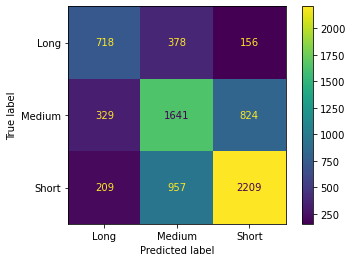

In [24]:
from sklearn import metrics
print('DecisionTree')
confusion_matrix = metrics.confusion_matrix(y_test, DTC_prediction)

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Long', 'Medium','Short'])

cm_display1.plot()

ExtraTree


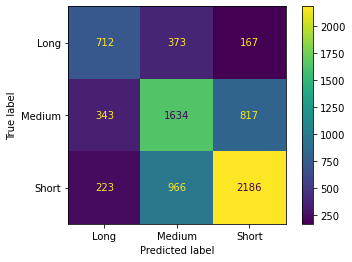

In [25]:
print('ExtraTree')
confusion_matrix = metrics.confusion_matrix(y_test, ETC_prediction)

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Long', 'Medium','Short'])

cm_display1.plot()

RandomForest


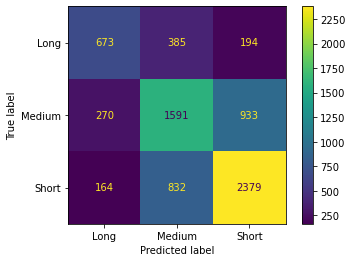

In [26]:
print('RandomForest')
confusion_matrix = metrics.confusion_matrix(y_test, RFC_prediction)

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Long', 'Medium','Short'])

cm_display1.plot()

### Trail 2

In [27]:
DTC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID",  
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["FarePerMile","Passengers"
                            ])
])), ("DTC", DecisionTreeClassifier())])


ETC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID", 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["FarePerMile","Passengers"
                            ])
])), ("ETC", ExtraTreeClassifier())])


RFC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "OriginCityMarketID", 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["FarePerMile","Passengers"
                            ])
])), ("RFC", RandomForestClassifier())])


In [28]:
%%time 
DTC_pipe_fil.fit(X_train, y_train)
ETC_pipe_fil.fit(X_train, y_train)

CPU times: user 1.87 s, sys: 45.9 ms, total: 1.92 s
Wall time: 1.92 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OriginCityMarketID',
                                                   'RPCarrier', 'RoundTrip',
                                                   'FareClass', 'OnLine']),
                                                 ('numerical_preprocessing',
                                                  StandardScaler(),
                                                  ['FarePerMile',
                                                   'Passengers'])])),
                ('ETC', ExtraTreeClassifier())])

In [29]:
%%time 
RFC_pipe_fil.fit(X_train, y_train)

CPU times: user 30.2 s, sys: 576 ms, total: 30.7 s
Wall time: 30.7 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OriginCityMarketID',
                                                   'RPCarrier', 'RoundTrip',
                                                   'FareClass', 'OnLine']),
                                                 ('numerical_preprocessing',
                                                  StandardScaler(),
                                                  ['FarePerMile',
                                                   'Passengers'])])),
                ('RFC', RandomForestClassifier())])

In [30]:
DTC_prediction = DTC_pipe_fil.predict(X_test)
ETC_prediction = ETC_pipe_fil.predict(X_test)
RFC_prediction = RFC_pipe_fil.predict(X_test)

In [31]:
# Accuracy score is the simplest way to evaluate
print(accuracy_score(DTC_prediction, y_test))
print(accuracy_score(ETC_prediction, y_test))
print(accuracy_score(RFC_prediction, y_test))

0.6357633742083277
0.6158199703543997
0.660018865382024


In [32]:
# But Confusion Matrix and Classification Report give more details about performance
print(classification_report(DTC_prediction, y_test))
print(classification_report(ETC_prediction, y_test))
print(classification_report(RFC_prediction, y_test))


              precision    recall  f1-score   support

   long-haul       0.57      0.57      0.57      1259
 medium-haul       0.55      0.57      0.56      2696
  short-haul       0.73      0.71      0.72      3466

    accuracy                           0.64      7421
   macro avg       0.62      0.62      0.62      7421
weighted avg       0.64      0.64      0.64      7421

              precision    recall  f1-score   support

   long-haul       0.55      0.53      0.54      1298
 medium-haul       0.53      0.54      0.54      2744
  short-haul       0.71      0.71      0.71      3379

    accuracy                           0.62      7421
   macro avg       0.60      0.59      0.59      7421
weighted avg       0.62      0.62      0.62      7421

              precision    recall  f1-score   support

   long-haul       0.57      0.60      0.58      1200
 medium-haul       0.57      0.59      0.58      2702
  short-haul       0.77      0.74      0.75      3519

    accuracy        

### Trail 3

In [33]:
DTC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "DestCityMarketID",  
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["FarePerMile","Passengers"
                            ])
])), ("DTC", DecisionTreeClassifier())])


ETC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "DestCityMarketID", 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["FarePerMile","Passengers"
                            ])
])), ("ETC", ExtraTreeClassifier())])


RFC_pipe_fil = Pipeline([("preprocess", ColumnTransformer([
    ('categorical_preprocessing', encode, [ 
                    "DestCityMarketID", 
                            "RPCarrier", "RoundTrip", "FareClass",'OnLine']),
    ('numerical_preprocessing', scaler, ["FarePerMile","Passengers"
                            ])
])), ("RFC", RandomForestClassifier())])


In [34]:
%%time 
DTC_pipe_fil.fit(X_train, y_train)
ETC_pipe_fil.fit(X_train, y_train)

CPU times: user 1.86 s, sys: 45.9 ms, total: 1.9 s
Wall time: 1.9 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DestCityMarketID',
                                                   'RPCarrier', 'RoundTrip',
                                                   'FareClass', 'OnLine']),
                                                 ('numerical_preprocessing',
                                                  StandardScaler(),
                                                  ['FarePerMile',
                                                   'Passengers'])])),
                ('ETC', ExtraTreeClassifier())])

In [35]:
%%time 
RFC_pipe_fil.fit(X_train, y_train)

CPU times: user 29.2 s, sys: 617 ms, total: 29.8 s
Wall time: 29.8 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DestCityMarketID',
                                                   'RPCarrier', 'RoundTrip',
                                                   'FareClass', 'OnLine']),
                                                 ('numerical_preprocessing',
                                                  StandardScaler(),
                                                  ['FarePerMile',
                                                   'Passengers'])])),
                ('RFC', RandomForestClassifier())])

In [36]:
DTC_prediction = DTC_pipe_fil.predict(X_test)
ETC_prediction = ETC_pipe_fil.predict(X_test)
RFC_prediction = RFC_pipe_fil.predict(X_test)

In [37]:
# Accuracy score is the simplest way to evaluate
print(accuracy_score(DTC_prediction, y_test))
print(accuracy_score(ETC_prediction, y_test))
print(accuracy_score(RFC_prediction, y_test))

0.6371109014957553
0.6156852176256569
0.6647352108880205


In [38]:
# But Confusion Matrix and Classification Report give more details about performance
print(classification_report(DTC_prediction, y_test))
print(classification_report(ETC_prediction, y_test))
print(classification_report(RFC_prediction, y_test))

              precision    recall  f1-score   support

   long-haul       0.56      0.56      0.56      1260
 medium-haul       0.55      0.57      0.56      2691
  short-haul       0.74      0.72      0.73      3470

    accuracy                           0.64      7421
   macro avg       0.62      0.62      0.62      7421
weighted avg       0.64      0.64      0.64      7421

              precision    recall  f1-score   support

   long-haul       0.52      0.51      0.52      1272
 medium-haul       0.55      0.55      0.55      2793
  short-haul       0.71      0.71      0.71      3356

    accuracy                           0.62      7421
   macro avg       0.59      0.59      0.59      7421
weighted avg       0.62      0.62      0.62      7421

              precision    recall  f1-score   support

   long-haul       0.57      0.60      0.58      1190
 medium-haul       0.58      0.60      0.59      2715
  short-haul       0.77      0.74      0.75      3516

    accuracy        